In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys

from tqdm import tqdm
import pickle
import h5py

import numpy as np
from astropy.cosmology import Planck18
from astropy import units as u
from astropy import constants as const

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## 1. Get

In [4]:
rec_base = np.load("../outputs/dm21cm/xc/xc_records.npy", allow_pickle=True).item()
rec_phph = np.load(f"../outputs/dm21cm/xcis_phph_lifetime25_noLX_nopop2_allbath_records.npy", allow_pickle=True).item()
rec = np.load(f"../outputs/dm21cm/xdecay_dc_records.npy", allow_pickle=True).item()

In [5]:
i = 100

In [6]:
x_H_s = rec['x_H_slice'][i].flatten()
delta_s = rec['delta_slice'][i].flatten()
phot_N = rec['phot_N'][i]

## 2. Apply tf

In [17]:
sys.path.append("..")
from dm21cm.utils import load_h5_dict
from dm21cm.dh_wrappers import TransferFunctionWrapper
import dm21cm.physics as phys
from dm21cm.dm_params import DMParams
from darkhistory.spec.spectrum import Spectrum

In [8]:
data_dir = os.environ['DM21CM_DATA_DIR'] + '/tf/zf01/data'
abscs = load_h5_dict(f"{data_dir}/abscissas.h5")
photeng = abscs['photE']

In [9]:
tf_wrapper = TransferFunctionWrapper(
    box_dim = 1,
    abscs = abscs,
    prefix = data_dir,
    enable_elec = False,
    on_device = True,
)

In [10]:
rs = rec['z'][i] + 1
print(rs)

n = 10

16.72063435960098


In [11]:
dm_params = DMParams(
    mode='decay',
    primary='phot_delta',
    m_DM=1e8, # [eV]
    lifetime=1e25, # [s]
)
dm_params.set_inj_specs(abscs)

In [12]:
z_current = rs - 1
delta_plus_one_box = delta_s + 1
nBavg = phys.n_B * (1+z_current)**3 # [Bavg / (physical cm)^3]
rho_DM_box = delta_plus_one_box * phys.rho_DM * (1+z_current)**3 # [eV/(physical cm)^3]
dt = phys.dt_step(z_current, np.exp(abscs['dlnz']))
inj_per_Bavg_box = phys.inj_rate(rho_DM_box, dm_params) * dt * dm_params.struct_boost(1+z_current) / nBavg

In [13]:
dm_out = tf_wrapper.phot_scat_tf(
    in_spec=rec_phph['phot_N'][i],
    sum_result=False,
    x_s=x_H_s[:n],
    nBs_s=1+delta_s[:n],
    rs=rs,
    out_of_bounds_action='clip'
) * inj_per_Bavg_box[:n,None]

In [14]:
i_start = np.argmin(np.abs(photeng - 1e2))
i_end   = np.argmin(np.abs(photeng - 1e4))

In [15]:
n = 20
dm_out = tf_wrapper.phot_scat_tf(
    in_spec=dm_params.inj_phot_spec.N,
    sum_result=False,
    x_s=np.random.uniform(0., 1., size=n),
    nBs_s=np.random.uniform(0., 2.5, size=n),
    rs=rs,
    out_of_bounds_action='clip'
) * inj_per_Bavg_box[:n,None]
print(np.mean(np.einsum('ij,j->i', dm_out, photeng)))

dm_out += tf_wrapper.phot_scat_tf(
    in_spec=rec_phph['phot_N'][i],
    sum_result=False,
    x_s=np.random.uniform(0., 1., size=n),
    nBs_s=np.random.uniform(0., 2.5, size=n),
    rs=rs,
    out_of_bounds_action='clip'
)
print(np.mean(np.einsum('ij,j->i', dm_out, photeng)))

6.6254338552152326e-06
0.00023518924710499116


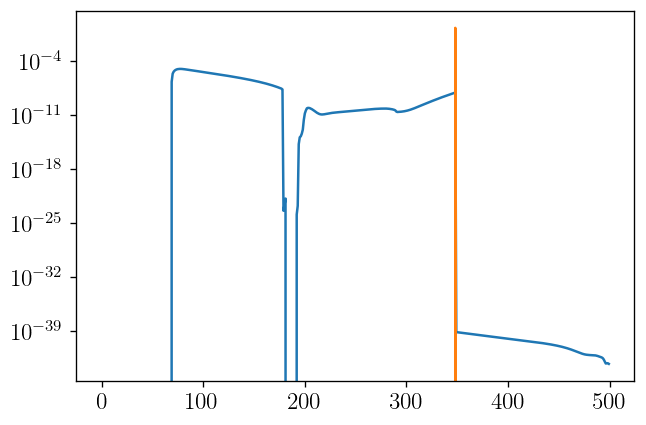

In [16]:
plt.plot(rec_phph['phot_N'][i])
plt.plot(dm_params.inj_phot_spec.N)
plt.yscale('log')

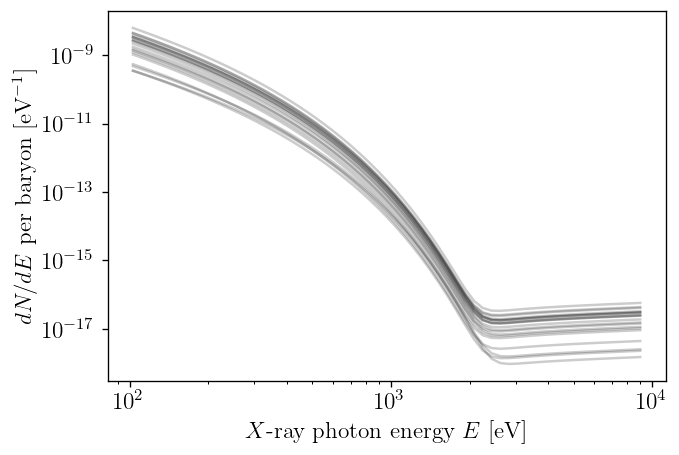

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
ax = axs
for s in dm_out:
    spec = Spectrum(photeng, s, spec_type='N')
    ax.plot(photeng[i_start:i_end], spec.dNdE[i_start:i_end], color='k', alpha=0.2)
ax.set(xscale='log', yscale='log', xlabel='$X$-ray photon energy $E$ [eV]', ylabel=r'$dN/dE$ per baryon [eV$^{-1}$]');

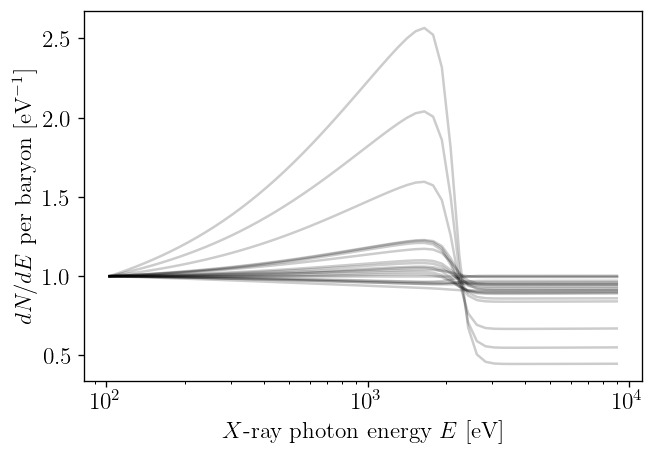

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))
ax = axs

base_spec = Spectrum(photeng, dm_out[0], spec_type='N')
dNdE_base = base_spec.dNdE[i_start:i_end]
dNdE_base /= dNdE_base[0]
for s in dm_out:
    spec = Spectrum(photeng, s, spec_type='N')
    dNdE = spec.dNdE[i_start:i_end]
    dNdE /= dNdE[0]
    ax.plot(photeng[i_start:i_end], dNdE/dNdE_base, color='k', alpha=0.2)
ax.set(xscale='log', xlabel='$X$-ray photon energy $E$ [eV]', ylabel=r'$dN/dE$ per baryon [eV$^{-1}$]');

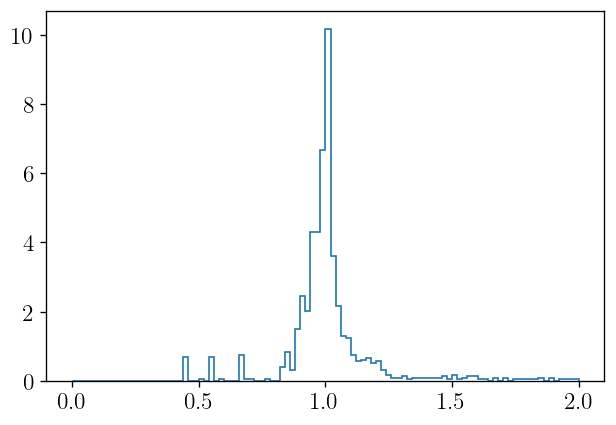

In [23]:
diffs = []
base_spec = Spectrum(photeng, dm_out[0], spec_type='N')
dNdE_base = base_spec.dNdE[i_start:i_end]
dNdE_base /= dNdE_base[0]
for s in dm_out:
    spec = Spectrum(photeng, s, spec_type='N')
    dNdE = spec.dNdE[i_start:i_end]
    dNdE /= dNdE[0]
    diffs.append(dNdE/dNdE_base)
plt.hist(np.array(diffs).flatten(), bins=100, range=(0, 2), histtype='step', density=True);